# Imports

In [97]:
!cat /proc/meminfo | grep Mem

MemTotal:       527960256 kB
MemFree:        15899064 kB
MemAvailable:   473760252 kB


In [2]:
import multiprocessing

multiprocessing.cpu_count()

128

In [3]:
20349632 /1024**2

19.40692138671875

In [4]:
import pickle

In [56]:
from typing import Union, List

In [5]:
import pandas as pd
import numpy as np
import os, sys
import warnings
import random
import json

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# f = os.path.dirname(__file__)
sys.path.append(os.path.join(os.getcwd(), "../.."))
from tqdm import tqdm
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, auc, roc_curve, \
    balanced_accuracy_score, precision_recall_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from scipy import stats
import networkx as nx
from collections import defaultdict
from sklearn.decomposition import PCA
import pickle
# import dill
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from detection.detection_utils.factory import create_dir_if_missing
from config.detection_config import user_level_execution_config, user_level_conf, post_level_execution_config

# sns.set(rc={'figure.figsize': (10, 10)}, font_scale=1.4)
from scipy.optimize import minimize
from utils.my_timeit import timeit
from utils.general import init_log

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0, multivariate=True, group=True, warn_independent_sampling=False ,**optuna.samplers.TPESampler.hyperopt_parameters())

logger = init_log("user_level_simple_models")

os.chdir('/sise/home/tommarz/hate_speech_detection/')
os.getcwd()

'/sise/home/tommarz/hate_speech_detection'

# Helper

## Functions

In [6]:
def expect_precision(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    # idxs = np.where(y_prob < thres)[0]
    # fn = y_prob[idxs].sum()
    return tp/(tp+fp)

def expect_f1(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    idxs = np.where(y_prob < thres)[0]
    fn = y_prob[idxs].sum()
    return 2*tp / (2*tp + fp + fn)

def optimal_threshold(y_true, y_prob):
    y_prob = np.sort(y_prob)[::-1]
    f1s = [expect_f1(y_true, y_prob, p) for p in y_prob]
    thres = y_prob[np.argmax(f1s)]
    return thres #, f1s 

def get_hs_count(current_preds, threshold=0.5):
    return len(current_preds[current_preds > threshold])

def calc_metrics(y_true, y_pred):
    return {f.__name__:f(y_true, y_pred) for f in scoring_list}

def write_method_params_and_results(method_name, output_path, results_dict, overwrite=False):
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    for name, df in results_dict.items():
        path = os.path.join(output_path, f'{method_name}_{name}_results')
        # print(results_path)
        if not os.path.exists(f'{path}.csv') or overwrite:
            df.to_csv(f'{path}.csv')
        else:
            print(f'{name}.csv file already exists')
        if name != 'params':
            if (not os.path.exists(f'{path}.txt') or overwrite):
                np.savetxt(f'{path}.txt', df.values.T, fmt='%.3f', delimiter = ' & ')
            else:
                print(f'{name}.txt file already exists')

def read_method_params_and_results(method_name, output_path):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    params_path = os.path.join(output_path, f'{method_name}_best_params.txt')
    train_results_path = os.path.join(output_path, f'{method_name}_train_results.csv')
    test_results_path = os.path.join(output_path, f'{method_name}_test_results.csv')
    with open(params_path, 'r') as f:
        best_params = json.load(f)
    train_results = pd.read_csv(train_results_path)
    test_results = pd.read_csv(test_results_path)
    metrics_dict = {'train': train_results, 'test': test_results}
    return best_params, metrics_dict

def get_best_results_cv(results_cv, scoring_name=None, best_score_idx=None):
    scores_mean = results_cv.mean(axis=0)
    scores_std = results_cv.std(axis=0)
    
    if scoring_name is not None and best_score_idx is None:
        scoring_idx = get_scoring_idx_by_name(scoring_name)    
        scoring_mean = scores_mean[scoring_idx]
        scoring_std = scores_std[scoring_idx]
        best_score_idx = scoring_mean.argmax() if not best_score_idx else best_score_idx
    
        best_scores_mean = scores_mean[:, best_score_idx]
        best_scores_std = scores_std[:, best_score_idx]
        results_df = pd.DataFrame([best_scores_mean, best_scores_std], columns=scoring_names, index=['mean', 'std']).T

        return results_df, best_score_idx
    
    best_scores_mean = scores_mean[:, best_score_idx]
    best_scores_std = scores_std[:, best_score_idx]
    results_df = pd.DataFrame([best_scores_mean, best_scores_std], columns=scoring_names, index=['mean', 'std']).T
    
    return results_df

def get_scoring_idx_by_name(name):
    return [idx for idx, e in enumerate(scoring_list) if name in e.__name__][0]

def write_results_latex(df, name):
    with open(os.path.join(method_output_path, f'{method_name}_{name}_results_latex.txt'), 'w') as f:
        res = ' & '.join([f'${m:.3f} \pm {s:.3f}$' for m, s in df.values.reshape(-1, 2)]) + '\\\\'
        f.write(res)

def get_best_results_from_gs(gs):
    train_results = pd.DataFrame(pd.DataFrame.from_dict(gs.cv_results_).loc[
                                     gs.best_index_, [c for c in gs.cv_results_ if
                                                      'mean_train' in c or 'std_train' in c]].values.reshape(-1, 2),
                                 columns=['mean', 'std'], index=scoring_names)
    test_results = pd.DataFrame(pd.DataFrame.from_dict(gs.cv_results_).loc[gs.best_index_, [c for c in gs.cv_results_ if
                                                                                            'mean_test' in c or 'std_test' in c]].values.reshape(
        -1, 2), columns=['mean', 'std'], index=scoring_names)
    # best_hyper_params = pd.Series(gs.best_estimator_.get_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_hyperparams.csv'))
    return {'train': train_results, 'test': test_results}

def get_best_results_from_cv_results(cv_results):
    train_results =  pd.DataFrame(pd.DataFrame.from_dict(cv_results).loc[:, [c for c in cv_results if  'mean_train' in c or 'std_train' in c]].values.reshape(-1,2), columns=['mean', 'std'], index=scoring_names)
    test_results =  pd.DataFrame(pd.DataFrame.from_dict(cv_results).loc[:, [c for c in cv_results if  'mean_test' in c or 'std_test' in c]].values.reshape(-1,2), columns=['mean', 'std'], index=scoring_names)
    return {'train': train_results, 'test': test_results}

def write_best_results_and_params_from_gs(gs):
    results_dict = get_best_results_from_gs(gs)
    pd.Series(gs.best_estimator_.get_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_hyperparams.csv'))
    pd.Series(gs.best_estimator_.get_learned_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_params.csv'))

    for name, df in results_dict.items():
        write_results_latex(df, name=name)
        df.to_csv(os.path.join(method_output_path, f'best_results_{name}.csv'))
        
    return results_dict

In [7]:
f1_scores_lst = ['f1',
'f1_macro',
'f1_micro',
'f1_samples',
'f1_weighted']

In [8]:
scoring_list = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
scoring_names = ['_'.join(f.__name__.split('_')[:-1]) for f in [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]]
scoring_dict = {n:f for n, f in zip(scoring_names, scoring_list)}
# scoring_dict

In [9]:
get_hs_count_vec = FunctionTransformer(lambda x, post_threshold: np.vectorize(lambda p, post_threshold: (p>=post_threshold).sum())(x))

get_mean_hs_preds_vec = np.vectorize(lambda p: p.mean())

In [10]:
class HateSpeechCountTransformer(FunctionTransformer):
    def __init__(self, post_threshold=0.5):
        super().__init__()
        self.post_threshold=post_threshold
        self.f = np.vectorize(lambda p, post_threshold: (p>=post_threshold).sum())
        # self.feature_names_out = lambda self, input_features: ['hs_count']
        # self.feature_names_out = 'one_to_one'
    
    def transform(self, X):
        return self.f(X, self.post_threshold).reshape(-1, 1)
        
#     def fit_transform(self, X):
#         return self.transform(X)

In [11]:
class MeanHateSpeechProbaTransformer(FunctionTransformer):
    def __init__(self):
        super().__init__()
        self.f = np.vectorize(lambda p: p.mean())
        # self.feature_names_out = lambda self, input_features: ['mean_hs']
        # self.feature_names_out = 'one_to_one'
    
    def transform(self, X, y=None):
        return self.f(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.transform(X, y)

In [12]:
import sklearn
sklearn.__version__

'1.2.2'

# Config

## Dataset

In [13]:
dataset = user_level_execution_config["inference_data"]
logger.info(f"loading dataset {dataset}...")
model_name = post_level_execution_config["kwargs"]["model_name"]
user2pred = pd.read_parquet(f"detection/outputs/{dataset}/{model_name}/user_level/split_by_posts/no_text/")
if dataset == 'parler':
    user2pred_old = pd.read_parquet(f"detection/outputs/{dataset}/{model_name}/user_level_2500_users/split_by_posts/no_text/")
    user2pred = pd.concat([user2pred, user2pred_old])
# user2pred['user_id'] = user2pred['user_id'].astype(int)
user2label_path = user_level_conf[dataset]["data_path"]
sep = ","
if user2label_path.endswith("tsv"):
    sep = "\t"
y = pd.read_csv(user2label_path, sep=sep, index_col=[0]).squeeze()
y.index=  y.index.astype(str)
user2pred['user_id'] = user2pred['user_id'].astype(str)
# user2pred = user2pred[user2pred['user_id'].isin(labeled_users.index)]
labeled_user2pred = user2pred.query('`user_id` in @y.index')

predictions_output_path = os.path.join(post_level_execution_config["evaluation"]["output_path"], 'predictions.tsv')
predictions_df = pd.read_csv(predictions_output_path, sep='\t')
y_true = predictions_df['y_true']
y_prob = predictions_df['y_score']
y_pred = predictions_df['y_pred']

print(f'Percent HS Users: {y.mean()}')
# print(f'Percent HS Users: {y_test.mean()}')

2023-06-25 01:24:12,495 - INFO     - user_level_simple_models - loading dataset echo_2...
Percent HS Users: 0.154


In [14]:
user_key = user_level_conf[dataset]['user_unique_column']
user_key

'user_id'

In [15]:
user2pred_flat = user2pred.groupby(user_key)['predictions'].apply(np.array).reset_index().set_index(user_key)['predictions']
user2pred_flat

user_id
1000175330    [0.0021778708, 0.0033117726, 0.012569215, 0.00...
1000776464    [0.0041207206, 0.006738855, 0.0032901242, 0.00...
1000946450    [0.0017821302, 0.00265877, 0.007005457, 0.0035...
1000986720    [0.0050743017, 0.001918423, 0.32967195, 0.0022...
100139689     [0.05329563, 0.05529492, 0.2942021, 0.767084, ...
                                    ...                        
99728412      [0.024769176, 0.003029988, 0.004516106, 0.0051...
99778180      [0.0022323988, 0.0021831526, 0.0022091235, 0.0...
99792136      [0.9112673, 0.0029457465, 0.007306661, 0.00220...
99800389      [0.038976964, 0.014431078, 0.0018899991, 0.001...
998040487     [0.11851241, 0.02289959, 0.19659099, 0.6179952...
Name: predictions, Length: 7073, dtype: object

In [16]:
if dataset == 'echo_2':
    G = nx.read_weighted_edgelist("/sise/home/tommarz/Hateful-users-detection/Dataset/EchoData/network.weighted.edgelist.gz", delimiter='\t', create_using=nx.MultiDiGraph)
    doc_vectors = pickle.load(open("/sise/home/tommarz/Hateful-users-detection/Dataset/EchoData/Doc2Vec100.p", "rb"))

In [17]:
len(doc_vectors)

7073

In [18]:
G.number_of_nodes(), G.number_of_edges()

(11520, 566302)

In [19]:
nodes_str = user2pred_flat.index.astype(str).tolist()
nodes_int = user2pred_flat.index.astype(int).tolist()

In [20]:
set(doc_vectors.keys()) == set(nodes_str)

True

In [21]:
G_ = G.subgraph(nodes_str).copy()
G_.number_of_nodes(), G_.number_of_edges()

(5392, 71752)

In [22]:
G_.add_nodes_from(nodes_str)
G_.number_of_nodes(), G_.number_of_edges()

(7073, 71752)

In [23]:
el_echo_users_rt = pd.read_csv("/sise/Yalla_work/data/echoes/only_english/dfs_and_dicts/el_echo_users_rt.txt", sep='\t', header=None, names=['source', 'target', 'weight'])
# el_echo_users_rt['type'] = 'repost'
el_echo_users_rt

source              target  weight
0       720749074190872578  712248310686425088       2
1       736615251278475264          1669312890       1
2       714854660297895938            41866281       1
3                 67903191            16206579       2
4               4779468079          1630603508       1
...                    ...                 ...     ...
202321          2593747267          3294519901       1
202322            50127545            38445467       2
202323          3303369747          3105864599       6
202324          4819947663          2423373294       1
202325            88550047           404463989       1

[202326 rows x 3 columns]

In [24]:
rt_graph = nx.from_pandas_edgelist(el_echo_users_rt, create_using=nx.DiGraph, edge_attr=True)
rt_graph.number_of_nodes(), rt_graph.number_of_edges()

(10863, 202326)

In [25]:
rt_subgraph = rt_graph.subgraph(user2pred_flat.index.astype(int).tolist()).copy()
rt_subgraph.number_of_nodes(), rt_subgraph.number_of_edges()

(5346, 23901)

In [26]:
rt_subgraph.add_nodes_from(nodes_int)
rt_subgraph.number_of_nodes(), rt_subgraph.number_of_edges()

(7073, 23901)

In [27]:
X = user2pred_flat.loc[y.index]
X

user_id
231597325     [0.014254283, 0.0036554604, 0.0034985743, 0.00...
2190420108    [0.006928811, 0.00761229, 0.006928811, 0.00761...
548007350     [0.0018899991, 0.010226309, 0.00489348, 0.0134...
113526237     [0.0021909955, 0.0018158451, 0.9542984, 0.0082...
716664192     [0.0017960311, 0.0013771638, 0.002144911, 0.14...
                                    ...                        
225298549     [0.0018899991, 0.0018899991, 0.0018899991, 0.0...
460453341     [0.03182729, 0.035745457, 0.001818517, 0.00554...
88994026      [0.002539765, 0.0057639075, 0.0026813233, 0.05...
187450820     [0.0024212236, 0.0021088328, 0.0014777931, 0.0...
2974346781    [0.016878761, 0.0458644, 0.4242909, 0.10513318...
Name: predictions, Length: 1000, dtype: object

## Post Threshold

In [28]:
# def optimal_threshold(y_true, y_prob):
y_prob = np.sort(y_prob)[::-1]
precisions = [expect_precision(y_true, y_prob, p) for p in y_prob]
thres = y_prob[np.argmax(precisions)]
thres

0.9950218

In [29]:
post_threshold = optimal_threshold(y_true, y_prob)
# post_threshold=0.9
# post_threshold=thres
post_threshold

0.4196834

## Scoring 

In [30]:
# post_threshold=0.5
# post_threshold = 0.9
scoring_name = 'f1'
scoring = scoring_dict[scoring_name]
scoring_idx = get_scoring_idx_by_name(scoring_name)

In [31]:
scoring_name, scoring

('f1',
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

## Random State (Seed)

In [32]:
echo_seed = 1524604541
parler_seed = 1740177118
gab_seed = 1524604541

In [33]:
seed = echo_seed # random.randrange(2 ** 32)
print("Seed is:", seed)
output_path = f"detection/outputs/{dataset}/{model_name}/user_level/experiments/{seed}"
if os.path.exists(output_path):
    print(f"Output path {output_path} already exists.")
else:
    os.makedirs(output_path)
    print(f"Output path {output_path} created.")

Seed is: 1524604541
Output path detection/outputs/echo_2/BertFineTuning/user_level/experiments/1524604541 already exists.


In [34]:
best_th = optimal_threshold(y_true, y_prob)

In [35]:
test_size = 0.2
cv = 5

# Feature Extraction

## Transformers

In [36]:
def get_linear_weighted_average(a):
    weights =(np.arange(1, len(a)+1)[::-1])/len(a)
    return np.average(a, weights=weights)

In [37]:
def get_exp_weighted_average(a):
    weights = np.exp(range(-len(a), 0))[::-1]
    return np.average(a, weights=weights)

In [38]:
np.percentile([1,2,3], [])

array([], dtype=float64)

In [39]:
class HateSpeechStatsTransformer(FunctionTransformer):
    def __init__(self, post_threshold=None, percentiles=[]):
        super().__init__()
        features_names = []
        self.hs_count_func = lambda hs_probas: np.array([])
        self.post_threshold = post_threshold
        # percentiles = [] if not percentiles else percentiles
        self.percentiles = percentiles
        percentiles = np.array([]) if percentiles is None else percentiles
        if self.post_threshold is not None:
            self.hs_count_func = lambda hs_probas: np.array([(hs_probas>=self.post_threshold).sum(), (hs_probas>=self.post_threshold).mean(), (hs_probas>=self.post_threshold).std()])
            features_names.extend(['hs_count', 'hs_count_mean', 'hs_count_std'])
        self.hs_probas_func = lambda hs_probas: np.array([hs_probas.mean(), hs_probas.std(), get_exp_weighted_average(hs_probas), get_linear_weighted_average(hs_probas)])
        features_names.extend(['hs_proba_mean', 'hs_proba_std', 'hs_proba_exp_weighted_avg', 'hs_proba_linear_weighted_avg'])
        self.hs_percentiles_func = lambda hs_probas: np.array([])
        if len(self.percentiles)>0:
            self.hs_percentiles_func = lambda hs_probas: np.percentile(hs_probas, q=self.percentiles)
            features_names.extend([f'hs_proba_{q}' for q in self.percentiles])
        self.func = np.vectorize(lambda hs_probas: np.hstack((self.hs_count_func(hs_probas), self.hs_probas_func(hs_probas), self.hs_percentiles_func(hs_probas))), signature='()->(n)')
        self.feature_names_out = lambda self, input_features: features_names
        self.set_output(transform='pandas')

In [40]:
hs_transformer = HateSpeechStatsTransformer(post_threshold=0.5, percentiles=[25])

In [41]:
hs_transformer.get_feature_names_out()

array(['hs_count', 'hs_count_mean', 'hs_count_std', 'hs_proba_mean',
       'hs_proba_std', 'hs_proba_exp_weighted_avg',
       'hs_proba_linear_weighted_avg', 'hs_proba_25'], dtype=object)

In [42]:
hs_transformer.fit_transform(X)

hs_count  hs_count_mean  hs_count_std  hs_proba_mean  \
user_id                                                            
231597325      123.0       0.038789      0.193092       0.053907   
2190420108      85.0       0.026505      0.160630       0.048457   
548007350      431.0       0.162519      0.368926       0.175734   
113526237      213.0       0.066376      0.248938       0.094124   
716664192       69.0       0.046590      0.210759       0.066912   
...              ...            ...           ...            ...   
225298549      201.0       0.063628      0.244089       0.085455   
460453341      454.0       0.142231      0.349286       0.166432   
88994026        30.0       0.009302      0.095999       0.018214   
187450820       62.0       0.019454      0.138114       0.026376   
2974346781     850.0       0.313076      0.463745       0.321396   

            hs_proba_std  hs_proba_exp_weighted_avg  \
user_id                                               
231597325       0.154619                   0.016157   
2190420108      0.113419                   0.007125   
548007350       0.298501                   0.005515   
113526237       0.200946                   0.083932   
716664192       0.173246                   0.006276   
...                  ...                        ...   
225298549       0.197794                   0.001900   
460453341       0.274408                   0.034764   
88994026        0.076636                   0.004940   
187450820       0.115766                   0.002256   
2974346781      0.369856                   0.068574   

            hs_proba_linear_weighted_avg  hs_proba_25  
user_id                                                
231597325                       0.055091     0.002526  
2190420108                      0.045002     0.007899  
548007350                       0.156972     0.003976  
113526237                       0.090344     0.004791  
716664192                       0.065799     0.002958  
...                                  ...          ...  
225298549                       0.080619     0.003180  
460453341                       0.165864     0.007299  
88994026                        0.017747     0.003196  
187450820                       0.025066     0.001880  
2974346781                      0.325291     0.012678  

[1000 rows x 8 columns]

## Load Network Data
Edge Key: 0 = Repost, 1 = Reply, 2 = Mention

In [43]:
network_dir = f"hate_networks/outputs/{dataset.split('_')[0]}_networks/network_data/"
edges_dir = os.path.join(network_dir, "edges")
mentions_df = pd.read_csv(os.path.join(edges_dir, "data_users_mention_edges_df.tsv"), sep='\t')
retweets_df = pd.read_csv(os.path.join(edges_dir, "data_users_retweet_edges_df.tsv"), sep='\t')

In [44]:
mentions_df

source                dest  weight
0       231597325           711114318       1
1      2190420108           743250048      89
2      2190420108           327101229     112
3       548007350          2438013757      24
4       548007350            25743339      13
...           ...                 ...     ...
35100  3223728264           113137765       3
35101  3223728264  700544106594856961       1
35102   232393683            32238490       1
35103   344962825            21035409       1
35104   344962825          3418857281       1

[35105 rows x 3 columns]

In [45]:
G_ = nx.from_pandas_edgelist(mentions_df, target='dest', create_using=nx.DiGraph, edge_attr=True)
G_.number_of_nodes(), G_.number_of_edges()

(4685, 35105)

In [61]:
if dataset == 'echo_2' and not 'G' in globals():
    G = nx.read_weighted_edgelist("/sise/home/tommarz/Hateful-users-detection/Dataset/EchoData/network.weighted.edgelist.gz", create_using=nx.MultiDiGraph, delimiter='\t')
if dataset == 'parler' and not 'G' in globals():
    G = nx.read_weighted_edgelist("/sise/home/tommarz/Hateful-users-detection/Dataset/ParlerData/ego_network.weighted.edgelist.gz", create_using=nx.MultiDiGraph, delimiter='\t')

In [46]:
G.number_of_nodes(), G.number_of_edges()

(11520, 566302)

In [47]:
doc_vectors = pickle.load(open("/sise/home/tommarz/Hateful-users-detection/Dataset/EchoData/Doc2Vec100.p", "rb"))

In [49]:
set(user2pred_flat.index).difference(set(doc_vectors))

set()

In [50]:
H = G.subgraph(doc_vectors)
H.number_of_nodes(), H.number_of_edges()

(5392, 71752)

In [51]:
len(set(doc_vectors).intersection(set(H.nodes)))

5392

In [52]:
labeled_users = labeled_user2pred['user_id'].unique().tolist() 

In [69]:
class RelationalTransformer(TransformerMixin):
    def __init__(self, user2pred, G: nx.Graph, post_threshold=None, percentiles=[], relation_types:List = [0, 1, 2], min_weight: Union[List, int] = [1,1,1], feat_to_use = None):
        super().__init__()
        self.hs_transformer = HateSpeechStatsTransformer(post_threshold, percentiles)
        self.G = G
        self.relation_types = relation_types
        self.min_weight = min_weight
        self.feat_to_use = feat_to_use
        self.user2pred = user2pred
        
    def get_neighbours_features(self, users2pred, G, filtered_edges):
        H = G.edge_subgraph(filtered_edges).copy()
        H.add_nodes_from(users2pred)

        H_merged = nx.DiGraph()
        H_merged.add_nodes_from(labeled_users)
        for u, v, k, attr in H.edges(data=True, keys=True):
            w = attr['weight'] if 'weight' in attr else 1.0
            if H_merged.has_edge(u, v):
                H_merged[u][v]['weight'] += w
            else:
                H_merged.add_edge(u, v, weight=w)
                
        neighbors_dict = {n: np.array([np.array([u, int(d['weight'])]) for u, d in H_merged[n].items() if u in self.user2pred_transformed.index]) for n in users2pred}

        neighbors_features_dict = {n: np.average(self.user2pred_transformed.loc[neighbors_dict[n][:, 0]],
                                                              axis=0, weights=neighbors_dict[n][:, 1].astype(int)) for n in neighbors_dict if len(neighbors_dict[n])>0}
        return neighbors_features_dict
    
    def get_relational_features(self, X: pd.DataFrame, G: nx.Graph, relation_types:List = [0, 1, 2], min_weight: Union[List, int] = [1,1,1], feat_to_use = None):
    
        if type(min_weight)==int:
            min_weight = [min_weight]*len(relation_types)

        filtered_edges_following = [(u,v,k) for u,v,k,attr in G.edges(data=True, keys=True) if attr['weight']>=min_weight[k] and k in relation_types and u in X.index]

        filtered_edges_followees = [(u,v,k) for u,v,k,attr in G.edges(data=True, keys=True) if attr['weight']>=min_weight[k] and k in relation_types and v in X.index]
        
        following_features_dict = self.get_neighbours_features(X.index, G, filtered_edges_following)
        followees_features_dict = self.get_neighbours_features(X.index, G, filtered_edges_followees)

        if feat_to_use is None:
            feat_to_use = X.columns

        following_features_df = pd.DataFrame.from_dict(following_features_dict, orient='index', columns=self.user2pred_transformed.columns)[feat_to_use].rename(columns={c: f'{c}_following' for c in feat_to_use})
        followees_features_df = pd.DataFrame.from_dict(followees_features_dict, orient='index', columns=self.user2pred_transformed.columns)[feat_to_use].rename(columns={c: f'{c}_followees' for c in feat_to_use})
        user2pred_features = X.loc[:, feat_to_use]

        user2pred_with_relational_features = pd.concat([user2pred_features, following_features_df, followees_features_df], axis=1).fillna(0)

        return user2pred_with_relational_features
    
    
    def fit(self, X, y=None):
        self.user2pred_transformed = self.hs_transformer.fit_transform(self.user2pred)
        self.user2pred_transformed.index = self.user2pred_transformed.index.astype(str)
        return self
    
    def transform(self, X, y=None):
        hs_features = self.user2pred_transformed.loc[X.index]
        return self.get_relational_features(hs_features, self.G, self.relation_types, self.min_weight, self.feat_to_use)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

# Train Classifier

## Logistic Regression

### Without Relational Features

In [255]:
pipe = make_pipeline(HateSpeechStatsTransformer(), StandardScaler(), LogisticRegression(random_state=seed))
pipe

Pipeline(steps=[('hatespeechstatstransformer', HateSpeechStatsTransformer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=1524604541))])

In [256]:
pipe.named_steps

{'hatespeechstatstransformer': HateSpeechStatsTransformer(),
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(random_state=1524604541)}

In [263]:
param_grid = {
    'hatespeechstatstransformer__post_threshold': [None, 0.5, best_th],
    'hatespeechstatstransformer__percentiles': [[], [25,50,75], [50]],
    'logisticregression__C': [1, 1e-1, 1e-2],
    'logisticregression__class_weight': [None, 'balanced']
}

In [258]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=30)

In [260]:
gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1524604541, shuffle=True),
             estimator=Pipeline(steps=[('hatespeechstatstransformer',
                                        HateSpeechStatsTransformer()),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1524604541))]),
             n_jobs=30,
             param_grid={'hatespeechstatstransformer__percentiles': [[25, 50,
                                                                      75],
                                                                     [50]],
                         'hatespeechstatstransformer__post_threshold': [None,
                                                                        0.5,
                                                                        0.4196834],
                         'logisticregression__C': [1, 0.1, 0.01],
                         'logisticregression__class_weight': [None,
                                                              'balanced']},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [261]:
results_dict = get_best_results_from_gs(gs)
for name, df in results_dict.items():
    print(name)
    display(df)

train


mean       std
accuracy     0.9315  0.004213
precision   0.78975  0.009334
recall     0.756557  0.022188
f1         0.772708  0.015375
roc_auc    0.959499  0.003461

test


mean       std
accuracy       0.93  0.010488
precision  0.789449  0.040624
recall     0.747097  0.035665
f1         0.767109  0.031833
roc_auc    0.959074  0.013209

In [262]:
gs.best_estimator_

Pipeline(steps=[('hatespeechstatstransformer',
                 HateSpeechStatsTransformer(percentiles=[25, 50, 75])),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, random_state=1524604541))])

### With Relational Features

#### Train on Raw Features

In [99]:
pipe = make_pipeline(RelationalTransformer(user2pred_flat, G), StandardScaler(), LogisticRegression(random_state=seed))
pipe

Pipeline(steps=[('relationaltransformer',
                 <__main__.RelationalTransformer object at 0x7fa02718e940>),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=1524604541))])

In [100]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=64, verbose=1)

In [101]:
param_grid = {
    # 'relationaltransformer__post_threshold': [None, 0.5, best_th],
    # 'relationaltransformer__percentiles': [[], [25,50,75]],
    'logisticregression__C': [1,1e-1,1e-2], # np.logspace(-3, 0, 10),
    'logisticregression__class_weight': [None, 'balanced']
}

In [102]:
gs.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Traceback (most recent call last):
  File "/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/home/tommarz/.conda/envs/eyal_hate_speech/lib/py

Process LokyProcess-300:
Process LokyProcess-298:
Process LokyProcess-299:
Process LokyProcess-294:
Process LokyProcess-295:
Process LokyProcess-297:
Process LokyProcess-296:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
Traceback (most recent call last):
  File "/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'decision_function'
KeyError: 'predict'

During handling of the above exception, another exception occurred:


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
    return s

In [ ]:
results_dict = get_best_results_from_gs(gs)
for name, df in results_dict.items():
    print(name)
    display(df)

#### Train on Relational Features

In [103]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=seed))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=1524604541))])

In [104]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=120, verbose=1)

In [105]:
param_grid = {
    'logisticregression__C': [1,1e-1,1e-2], # np.logspace(-3, 0, 10),
    'logisticregression__class_weight': [None, 'balanced']
}

In [66]:
rt = RelationalTransformer(user2pred_flat, G)
X_transformed_relational = rt.fit_transform(X)

In [106]:
gs.fit(X_transformed_relational, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1524604541, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1524604541))]),
             n_jobs=120,
             param_grid={'logisticregression__C': [1, 0.1, 0.01],
                         'logisticregression__class_weight': [None,
                                                              'balanced']},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [107]:
results_dict = get_best_results_from_gs(gs)
for name, df in results_dict.items():
    print(name)
    display(df)

train


mean       std
accuracy      0.942  0.005397
precision  0.833244  0.015578
recall     0.779255  0.022263
f1         0.805304  0.018682
roc_auc    0.967728  0.002391

test


mean       std
accuracy      0.941   0.01772
precision   0.83378   0.06299
recall     0.773333  0.063236
f1         0.801677  0.058102
roc_auc    0.965693  0.009762

In [108]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, random_state=1524604541))])

In [110]:
full_pipe = make_pipeline(rt , gs.best_estimator_)
full_pipe

Pipeline(steps=[('relationaltransformer',
                 <__main__.RelationalTransformer object at 0x7f9e312b7df0>),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(C=0.1,
                                                     random_state=1524604541))]))])

In [111]:
probas = full_pipe.predict_proba(X)

In [114]:
y

user_id
231597325     0
2190420108    0
548007350     1
113526237     0
716664192     0
             ..
225298549     0
460453341     0
88994026      0
187450820     0
2974346781    1
Name: label, Length: 1000, dtype: int64

In [118]:
roc_auc_score(y, probas[:, 1]), f1_score(y, probas[:, 1]>0.5)

(0.9676783027846859, 0.802675585284281)

In [301]:
model =  gs.best_estimator_.steps[-1][1]
model

LogisticRegression(C=0.001, class_weight='balanced', random_state=1740177118)

In [150]:
importances = model.coef_[0]
# Sort the feature importances in descending order
indices = np.argsort(importances)
feature_names = X_transformed_relational.columns

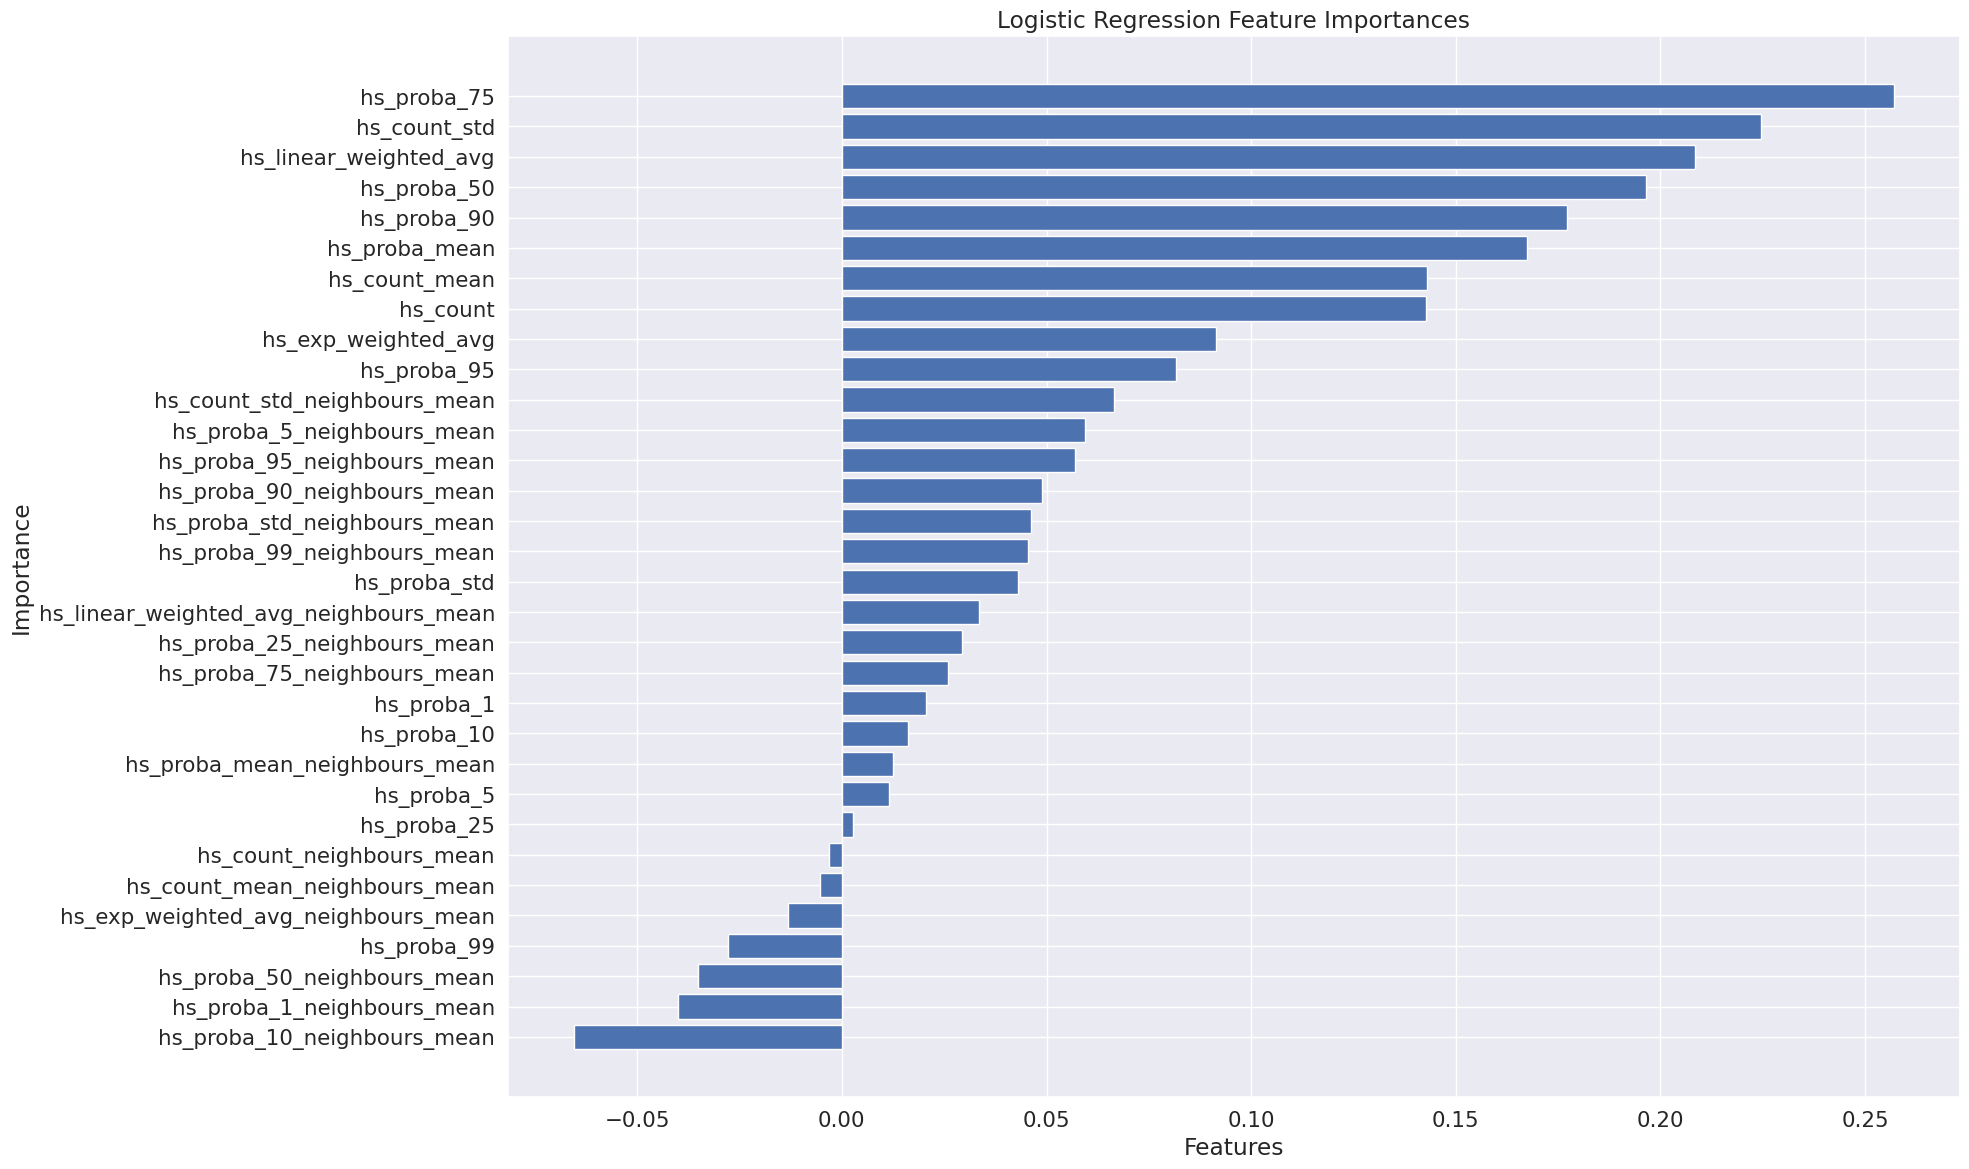

In [151]:
# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), feature_names[indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Logistic Regression Feature Importances')
plt.tight_layout()
plt.show()

In [101]:
X_ = gs.best_estimator_.steps[:-1][0][1].transform(X_transformed_relational)
# X = X_transformed_relational

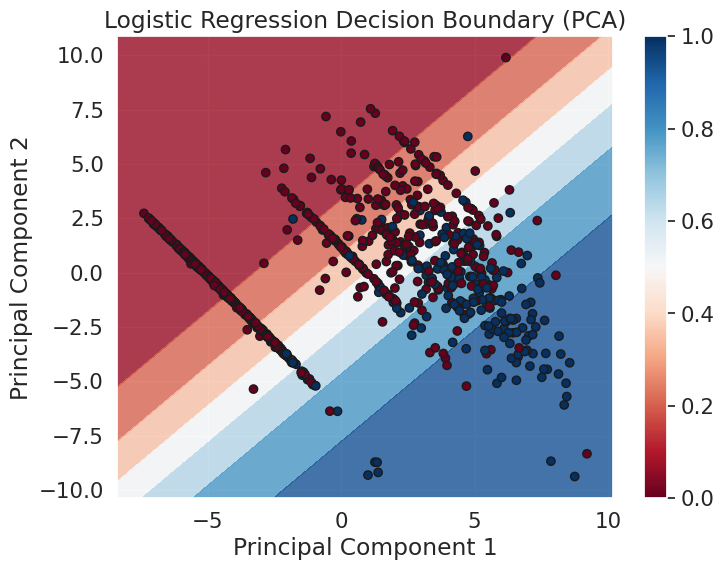

In [102]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_)

# Train a logistic regression model on the reduced dataset
# model = LogisticRegression()
model.fit(X_pca, y)

# Retrieve the coefficients and intercept
coef = model.coef_[0]
intercept = model.intercept_

# Define the range for the grid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
h = 0.02  # step size in the mesh

# Generate a grid of points
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class probabilities for each point in the grid
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the decision boundary in the reduced feature space
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Logistic Regression Decision Boundary (PCA)')
plt.colorbar()
plt.show()

## SVC

In [277]:
pipe = make_pipeline(HateSpeechStatsTransformer(), StandardScaler(), SVC(probability=True, random_state=seed))
pipe

Pipeline(steps=[('hatespeechstatstransformer', HateSpeechStatsTransformer()),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True, random_state=1524604541))])

In [278]:
pipe.named_steps

{'hatespeechstatstransformer': HateSpeechStatsTransformer(),
 'standardscaler': StandardScaler(),
 'svc': SVC(probability=True, random_state=1524604541)}

In [288]:
param_grid = {
    'hatespeechstatstransformer__post_threshold': [best_th, 0.5, None],
    'hatespeechstatstransformer__percentiles': [[], [25,50,75]],
    'svc__C': [1, 1e-1, 1e-2],
    'svc__class_weight': [None, 'balanced'],
    'svc__kernel': ['rbf']
}

In [289]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=30, verbose=10)

In [290]:
gs.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 27/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=1, svc__class_weight=balanced, svc__kernel=rbf; accuracy: (train=0.899, test=0.915) f1: (train=0.733, test=0.754) precision: (train=0.620, test=0.667) recall: (train=0.895, test=0.867) roc_auc: (train=0.939, test=0.964) total time=   0.6s
[CV 1/5; 33/108] START hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=rbf
[CV 1/5; 33/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=rbf; accuracy: (train=0.845, test=0.850) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.934, test=0.959) total time=   0.6s
[CV 5/5; 38/108] START hatespeechstatstransformer_

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

[CV 5/5; 34/108] START hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=linear
[CV 5/5; 34/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=linear; accuracy: (train=0.934, test=0.930) f1: (train=0.774, test=0.759) precision: (train=0.812, test=0.815) recall: (train=0.740, test=0.710) roc_auc: (train=0.957, test=0.951) total time=   0.7s
[CV 4/5; 40/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=balanced, svc__kernel=linear
[CV 4/5; 40/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=balanced, svc__kernel=linear; accuracy: (train=0.901, test=0.900) f1: (train=0.738, test=0.722) precision: (train=0.624, 

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5; 27/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=1, svc__class_weight=balanced, svc__kernel=rbf; accuracy: (train=0.909, test=0.890) f1: (train=0.749, test=0.711) precision: (train=0.649, test=0.600) recall: (train=0.886, test=0.871) roc_auc: (train=0.941, test=0.930) total time=   0.6s
[CV 4/5; 33/108] START hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=rbf
[CV 4/5; 33/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=rbf; accuracy: (train=0.846, test=0.845) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.948, test=0.901) total time=   0.6s
[CV 4/5; 39/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_th

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

[CV 2/5; 35/108] START hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=balanced, svc__kernel=rbf
[CV 2/5; 35/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=balanced, svc__kernel=rbf; accuracy: (train=0.879, test=0.880) f1: (train=0.688, test=0.714) precision: (train=0.569, test=0.566) recall: (train=0.870, test=0.968) roc_auc: (train=0.944, test=0.963) total time=   0.7s
[CV 5/5; 40/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=balanced, svc__kernel=linear
[CV 5/5; 40/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=balanced, svc__kernel=linear; accuracy: (train=0.905, test=0.885) f1: (train=0.743, test=0.701) precision: (train=0.636

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

[CV 3/5; 32/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.1, svc__class_weight=balanced, svc__kernel=linear; accuracy: (train=0.904, test=0.900) f1: (train=0.739, test=0.737) precision: (train=0.634, test=0.622) recall: (train=0.886, test=0.903) roc_auc: (train=0.960, test=0.954) total time=   0.6s
[CV 1/5; 38/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=None, svc__kernel=linear
[CV 1/5; 38/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=None, svc__kernel=linear; accuracy: (train=0.924, test=0.950) f1: (train=0.751, test=0.833) precision: (train=0.760, test=0.833) recall: (train=0.742, test=0.833) roc_auc: (train=0.956, test=0.968) total time=   0.6s
[CV 1/5; 44/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], 

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5; 36/108] START hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=balanced, svc__kernel=linear
[CV 4/5; 36/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=balanced, svc__kernel=linear; accuracy: (train=0.914, test=0.905) f1: (train=0.760, test=0.732) precision: (train=0.665, test=0.650) recall: (train=0.886, test=0.839) roc_auc: (train=0.962, test=0.940) total time=   0.6s
[CV 1/5; 42/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=0.1, svc__class_weight=None, svc__kernel=linear
[CV 1/5; 42/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=0.1, svc__class_weight=None, svc__kernel=linear; accuracy: (train=0.926, test=0.945) f1: (train=0.753, test=0.814) precision: (train=0.7

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5; 28/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=1, svc__class_weight=balanced, svc__kernel=linear; accuracy: (train=0.897, test=0.915) f1: (train=0.730, test=0.754) precision: (train=0.617, test=0.667) recall: (train=0.895, test=0.867) roc_auc: (train=0.957, test=0.970) total time=   0.6s
[CV 5/5; 33/108] START hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=rbf
[CV 5/5; 33/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=rbf; accuracy: (train=0.846, test=0.845) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.940, test=0.950) total time=   0.7s
[CV 2/5; 40/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

[CV 3/5; 33/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=rbf; accuracy: (train=0.846, test=0.845) f1: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.944, test=0.913) total time=   0.6s
[CV 3/5; 39/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=balanced, svc__kernel=rbf
[CV 3/5; 39/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=balanced, svc__kernel=rbf; accuracy: (train=0.895, test=0.905) f1: (train=0.724, test=0.747) precision: (train=0.608, test=0.636) recall: (train=0.894, test=0.903) roc_auc: (train=0.945, test=0.911) total time=   0.6s
[CV 3/5; 45/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hate

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

[CV 5/5; 32/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.1, svc__class_weight=balanced, svc__kernel=linear; accuracy: (train=0.907, test=0.890) f1: (train=0.748, test=0.711) precision: (train=0.643, test=0.600) recall: (train=0.894, test=0.871) roc_auc: (train=0.960, test=0.953) total time=   0.6s
[CV 4/5; 38/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=None, svc__kernel=linear
[CV 4/5; 38/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=None, svc__kernel=linear; accuracy: (train=0.931, test=0.925) f1: (train=0.781, test=0.746) precision: (train=0.766, test=0.786) recall: (train=0.797, test=0.710) roc_auc: (train=0.964, test=0.940) total time=   0.6s
[CV 5/5; 45/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], 

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5; 35/108] START hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=balanced, svc__kernel=rbf
[CV 3/5; 35/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=balanced, svc__kernel=rbf; accuracy: (train=0.880, test=0.870) f1: (train=0.694, test=0.683) precision: (train=0.571, test=0.549) recall: (train=0.886, test=0.903) roc_auc: (train=0.947, test=0.942) total time=   0.8s
[CV 4/5; 41/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=0.1, svc__class_weight=None, svc__kernel=rbf
[CV 4/5; 41/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=0.1, svc__class_weight=None, svc__kernel=rbf; accuracy: (train=0.930, test=0.930) f1: (train=0.767, test=0.759) precision: (train=0.786, test=0.8

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

[CV 1/5; 34/108] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=0.01, svc__class_weight=None, svc__kernel=linear; accuracy: (train=0.930, test=0.940) f1: (train=0.757, test=0.786) precision: (train=0.821, test=0.846) recall: (train=0.702, test=0.733) roc_auc: (train=0.954, test=0.965) total time=   0.6s
[CV 5/5; 39/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=balanced, svc__kernel=rbf
[CV 5/5; 39/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=balanced, svc__kernel=rbf; accuracy: (train=0.909, test=0.890) f1: (train=0.749, test=0.711) precision: (train=0.649, test=0.600) recall: (train=0.886, test=0.871) roc_auc: (train=0.941, test=0.930) total time=   0.8s
[CV 1/5; 46/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], h

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

[CV 5/5; 43/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=0.1, svc__class_weight=balanced, svc__kernel=rbf
[CV 5/5; 43/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=0.1, svc__class_weight=balanced, svc__kernel=rbf; accuracy: (train=0.895, test=0.880) f1: (train=0.724, test=0.692) precision: (train=0.608, test=0.574) recall: (train=0.894, test=0.871) roc_auc: (train=0.947, test=0.921) total time=   0.9s
[CV 4/5; 50/108] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.5, svc__C=1, svc__class_weight=None, svc__kernel=linear
[CV 4/5; 50/108] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.5, svc__C=1, svc__class_weight=None, svc__kernel=linear; accuracy: (train=0.931, test=0.925) f1: (train=0.781, test=0.746) precision: (tra

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1524604541, shuffle=True),
             estimator=Pipeline(steps=[('hatespeechstatstransformer',
                                        HateSpeechStatsTransformer()),
                                       ('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=1524604541))]),
             n_jobs=30,
             param_grid={'hatespeechstatstransformer__percentiles': [[],
                                                                     [25, 50,
                                                                      75]],
                         'hatespeechstatstransformer__post_threshold': [0.4196834,
                                                                        0.5,
                                                                        None],
                         'svc__C': [1, 0.1, 0.01],
                         'svc__class_weight': [None, 'balanced'],
                         'svc__kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=10)

In [291]:
results_dict = get_best_results_from_gs(gs)
for name, df in results_dict.items():
    print(name)
    display(df)

train


mean       std
accuracy    0.93025  0.001658
precision  0.789089  0.006085
recall     0.746787  0.011103
f1         0.767292  0.005948
roc_auc    0.916313  0.007207

test


mean       std
accuracy      0.929  0.008602
precision  0.783534  0.032306
recall     0.747097  0.029254
f1         0.764462  0.025167
roc_auc    0.911934  0.028082

In [292]:
gs.best_estimator_

Pipeline(steps=[('hatespeechstatstransformer',
                 HateSpeechStatsTransformer(post_threshold=0.4196834)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.1, probability=True, random_state=1524604541))])

## SGD

In [293]:
SGDClassifier()

SGDClassifier()

### With Relational Features

In [1024]:
X_transformed_relational.shape

(1000, 32)

In [294]:
pipe = make_pipeline(StandardScaler(), SGDClassifier(random_state=seed, early_stopping=True, class_weight='balanced'))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', early_stopping=True,
                               random_state=1524604541))])

In [295]:
pipe.named_steps

{'standardscaler': StandardScaler(),
 'sgdclassifier': SGDClassifier(class_weight='balanced', early_stopping=True,
               random_state=1524604541)}

In [296]:
param_grid = {
    # 'mlpclassifier__hidden_layer_sizes': [(2**i,2**(i-1)) for i in range(2, 8)],
    # 'mlpclassifier__learning_rate': ['adaptive', 'constant'],
    # 'mlpclassifier__activation': ['relu', 'sigmoid', 'tanh'],
    # 'mlpclassifier__learning_rate_init': [1e-3, 1e-2, 1e-1]
}

In [297]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=30, verbose=False)

In [298]:
gs.fit(X_transformed_relational, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1524604541, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      early_stopping=True,
                                                      random_state=1524604541))]),
             n_jobs=30, param_grid={}, refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=False)

In [299]:
results_dict = get_best_results_from_gs(gs)
for name, df in results_dict.items():
    print(name)
    display(df)

train


mean       std
accuracy    0.87525  0.039492
precision  0.565944  0.115798
recall     0.787359  0.211133
f1         0.651904  0.140039
roc_auc    0.875277  0.159895

test


mean       std
accuracy      0.873  0.040571
precision  0.565237  0.109519
recall     0.805376  0.164288
f1         0.660011  0.118066
roc_auc    0.877984  0.126134

In [300]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', early_stopping=True,
                               random_state=1524604541))])

In [994]:
model =  gs.best_estimator_.steps[-1][1]
model

LogisticRegression(C=0.1, random_state=1524604541)

## MLP

### With Relational Features

In [1024]:
X_transformed_relational.shape

(1000, 32)

In [1088]:
pipe = make_pipeline(StandardScaler(), MLPClassifier(random_state=seed, early_stopping=True, n_iter_no_change=200, max_iter=1000))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True, max_iter=1000,
                               n_iter_no_change=200,
                               random_state=1524604541))])

In [1056]:
pipe.named_steps

{'standardscaler': StandardScaler(),
 'mlpclassifier': MLPClassifier(early_stopping=True, max_iter=1000, n_iter_no_change=200,
               random_state=1524604541)}

In [1061]:
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(2**i,2**(i-1)) for i in range(2, 8)],
    'mlpclassifier__learning_rate': ['adaptive', 'constant'],
    'mlpclassifier__activation': ['relu', 'sigmoid', 'tanh'],
    'mlpclassifier__learning_rate_init': [1e-3, 1e-2, 1e-1]
}

In [1062]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=30, verbose=False)

In [1063]:
gs.fit(X_transformed_relational, y)

/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hate_speech/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tommarz/.conda/envs/eyal_hat

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1524604541, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpclassifier',
                                        MLPClassifier(early_stopping=True,
                                                      max_iter=1000,
                                                      n_iter_no_change=200,
                                                      random_state=1524604541))]),
             n_jobs=30,
             param_grid={'mlpclassifier__activation': ['relu', 'sigmoid',
                                                       'tanh'],
                         'mlpclassifier__hidden_layer_sizes': [(4, 2), (8, 4),
                                                               (16, 8),
                                                               (32, 16),
                                                               (64, 32),
                                                               (128, 64)],
                         'mlpclassifier__learning_rate': ['adaptive',
                                                          'constant'],
                         'mlpclassifier__learning_rate_init': [0.001, 0.01,
                                                               0.1]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=False)

In [1064]:
results_dict = get_best_results_from_gs(gs)
for name, df in results_dict.items():
    print(name)
    display(df)

train


mean       std
accuracy     0.9445  0.009925
precision  0.828563  0.056926
recall     0.813284  0.014858
f1         0.819573    0.0256
roc_auc    0.968371  0.007818

test


mean       std
accuracy      0.944  0.010198
precision  0.834695  0.055047
recall      0.79914  0.046136
f1         0.814774  0.031987
roc_auc    0.967488  0.008783

In [1065]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', early_stopping=True,
                               hidden_layer_sizes=(8, 4),
                               learning_rate='adaptive',
                               learning_rate_init=0.01, max_iter=1000,
                               n_iter_no_change=200,
                               random_state=1524604541))])

In [994]:
model =  gs.best_estimator_.steps[-1][1]
model

LogisticRegression(C=0.1, random_state=1524604541)

## GBDT

### XGBoost

In [304]:
def xgb_objective(trial, X, y, scoring=scoring):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "use_label_encoder": False,
        "n_jobs":30,
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 2.0, 5.0),
        "seed": seed
    }

    if params["booster"] == "gbtree" or params["booster"] == "dart":
        params["max_depth"] = trial.suggest_int("max_depth", 2, 6)
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 20, 50, step=5)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        params["subsample"] = trial.suggest_float("subsample", 0.2, 0.8)
        params["colsample_bytree"] = trial.suggest_float("subsample", 0.2, 1.0)
        params["colsample_bylevel"] = trial.suggest_float("subsample", 0.2, 1.0)
        params["colsample_bynode"] = trial.suggest_float("subsample", 0.2, 1.0)
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # Fit the model
    # pipe = make_pipeline(HateSpeechStatsTransformer(post_threshold=0.5,percentiles=[1,50,25,50,75,90,95,99]), StandardScaler(), xgb.XGBClassifier(**params))
    pipe = make_pipeline(StandardScaler(), xgb.XGBClassifier(**params))
    score = cross_val_score(pipe, X, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_name)
    # cv_results = cross_validate(pipe, X, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True)
    # trial.set_user_attr("cv_results", cv_results)
    trial.set_user_attr("pipe", pipe)
    return score.mean()   
    # return cv_results[f'test_{scoring}'].mean()

In [305]:
import optuna.logging
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.ERROR)

sampler = TPESampler(**TPESampler.hyperopt_parameters(), seed=seed)

study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(lambda trial: xgb_objective(trial, X_transformed_relational, y), n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [306]:
study.best_params

{'booster': 'gbtree',
 'lambda': 0.7550599301011529,
 'alpha': 0.001935964595077423,
 'scale_pos_weight': 2.9596403402574536,
 'max_depth': 2,
 'min_child_weight': 40,
 'eta': 6.834220790614245e-08,
 'subsample': 0.5943460737192365,
 'gamma': 1.4698876910463882e-05,
 'grow_policy': 'lossguide'}

In [307]:
best_pipe = study.best_trial.user_attrs['pipe']
best_pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.001935964595077423, base_score=None,
                               booster='gbtree',
                               colsample_bylevel=0.5943460737192365,
                               colsample_bynode=0.5943460737192365,
                               colsample_bytree=0.5943460737192365,
                               enable_categorical=False,
                               eta=6.834220790614245e-08, eval_metric='logloss',
                               gamma=1.4698876910463882e...
                               grow_policy='lossguide', importance_type=None,
                               interaction_constraints=None,
                               lambda=0.7550599301011529, learning_rate=None,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=40, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=30, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=2.9596403402574536,
                               seed=1524604541, ...))])

In [309]:
cv_results = cross_validate(best_pipe, X_transformed_relational, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True)

In [310]:
cv_results_df = pd.DataFrame.from_dict(cv_results)
cv_results_df = cv_results_df[[c for c in cv_results_df.columns if 'train' in c or 'test' in c]]
cv_results_df

test_accuracy  train_accuracy  test_precision  train_precision  \
0          0.935         0.92500        0.742857         0.705128   
1          0.930         0.93500        0.717949         0.744828   
2          0.925         0.93500        0.710526         0.738255   
3          0.935         0.92375        0.750000         0.696203   
4          0.905         0.93125        0.642857         0.723684   

   test_recall  train_recall   test_f1  train_f1  test_roc_auc  train_roc_auc  
0     0.866667      0.887097  0.800000  0.785714      0.971569       0.958616  
1     0.903226      0.878049  0.800000  0.805970      0.972228       0.958419  
2     0.870968      0.894309  0.782609  0.808824      0.958294       0.963259  
3     0.870968      0.894309  0.805970  0.782918      0.951422       0.965402  
4     0.870968      0.894309  0.739726  0.800000      0.936152       0.966009

In [311]:
cv_results_mean_df = cv_results_df.agg(['mean', 'std']).T
cv_results_mean_df

mean       std
test_accuracy    0.926000  0.012450
train_accuracy   0.930000  0.005376
test_precision   0.712838  0.042459
train_precision  0.721620  0.020842
test_recall      0.876559  0.015023
train_recall     0.889614  0.007180
test_f1          0.785661  0.027125
train_f1         0.796685  0.011773
test_roc_auc     0.957933  0.015060
train_roc_auc    0.962341  0.003637

[CV 5/5; 13/36] START hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=1, svc__class_weight=None, svc__kernel=rbf
[CV 5/5; 13/36] END hatespeechstatstransformer__percentiles=[], hatespeechstatstransformer__post_threshold=None, svc__C=1, svc__class_weight=None, svc__kernel=rbf; accuracy: (train=0.929, test=0.920) f1: (train=0.767, test=0.750) precision: (train=0.770, test=0.727) recall: (train=0.764, test=0.774) roc_auc: (train=0.905, test=0.893) total time=   0.6s
[CV 3/5; 19/36] START hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=None, svc__kernel=rbf
[CV 3/5; 19/36] END hatespeechstatstransformer__percentiles=[25, 50, 75], hatespeechstatstransformer__post_threshold=0.4196834, svc__C=1, svc__class_weight=None, svc__kernel=rbf; accuracy: (train=0.930, test=0.920) f1: (train=0.767, test=0.742) precision: (train=0.786, test=0.742) recall: (train=0.7

### LightGBM

In [151]:
def lgb_objective(trial, X, y, scoring=scoring):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": 0,
        "boosting_type": trial.suggest_categorical('boosting_type', ["gbdt", "dart"]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 16),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 50),
        "min_child_weight":trial.suggest_float("min_child_weight", 1, 1e1),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'min_split_gain': trial.suggest_float("min_split_gain", 1e-1, 1e2),
        "class_weight": "balanced",
        "silent": True,
        "n_jobs": 30,
        "random_state": seed,
        'importance_type': 'gain',
        'force_col_wise': True
    }

    pipe = make_pipeline(HateSpeechStatsTransformer(post_threshold=0.5, percentiles=[25,50,70]), lgb.LGBMClassifier(**params))
    score = cross_val_score(pipe, X, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_name)
    trial.set_user_attr("pipe", pipe)
    return score.mean()   

In [152]:
max_posts = int(X.apply(len).median())

In [153]:
from scipy.special import softmax

In [154]:
softmax(range(10)).sum()

1.0000000000000007

In [164]:
X_ = X.apply(lambda x: np.random.choice(x, np.minimum(len(x), 50), replace=False, p=softmax(range(len(x)))))

In [165]:
X_.apply(len)

user_id
100PercentPatriotic    50
1776tilinfinity        50
1955mjbret             50
1Andykorz              20
1Bambam1               50
                       ..
Pbones                 50
Pbots54                46
Peaceinliberty         29
Peaceloveandjoy        50
Pedrok128              34
Name: predictions, Length: 890, dtype: int64

In [184]:
import optuna.logging
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.ERROR)

sampler = TPESampler(**TPESampler.hyperopt_parameters(), seed=seed)

study = optuna.create_study(direction='maximize', sampler=sampler)

study.optimize(lambda trial: lgb_objective(trial, X_, y), n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [185]:
study.best_params

{'boosting_type': 'dart',
 'reg_alpha': 1.029372908412484e-06,
 'reg_lambda': 0.0015621562275757374,
 'num_leaves': 10,
 'max_depth': 3,
 'colsample_bytree': 0.9990249723586342,
 'subsample': 0.7983998975411621,
 'subsample_freq': 5,
 'min_child_samples': 22,
 'min_child_weight': 8.603593399247583,
 'min_split_gain': 60.86149099603513}

In [186]:
best_pipe = study.best_trial.user_attrs['pipe']
best_pipe

Pipeline(steps=[('hatespeechstatstransformer',
                 HateSpeechStatsTransformer(percentiles=[25, 50, 70],
                                            post_threshold=0.5)),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='dart', class_weight='balanced',
                                colsample_bytree=0.9990249723586342,
                                force_col_wise=True, importance_type='gain',
                                max_depth=3, metric='binary_logloss',
                                min_child_samples=22,
                                min_child_weight=8.603593399247583,
                                min_split_gain=60.86149099603513, n_jobs=30,
                                num_leaves=10, objective='binary',
                                random_state=1740177118,
                                reg_alpha=1.029372908412484e-06,
                                reg_lambda=0.0015621562275757374, silent=True,
                                subsample=0.7983998975411621, subsample_freq=5,
                                verbosity=0))])

In [187]:
cv_results = cross_validate(best_pipe, X_, y, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

In [188]:
cv_results_df = pd.DataFrame.from_dict(cv_results)
cv_results_df = cv_results_df[[c for c in cv_results_df.columns if 'train' in c or 'test' in c]]
cv_results_df

test_accuracy  train_accuracy  test_precision  train_precision  \
0       0.752809        0.786517        0.507692         0.554307   
1       0.803371        0.771067        0.583333         0.532847   
2       0.808989        0.769663        0.575342         0.532567   
3       0.792135        0.799157        0.571429         0.579167   
4       0.780899        0.789326        0.557377         0.560976   

   test_recall  train_recall   test_f1  train_f1  test_roc_auc  train_roc_auc  
0     0.733333      0.817680  0.600000  0.660714      0.803342       0.863148  
1     0.777778      0.806630  0.666667  0.641758      0.820969       0.838109  
2     0.933333      0.767956  0.711864  0.628959      0.882206       0.840445  
3     0.711111      0.767956  0.633663  0.660333      0.823810       0.838088  
4     0.739130      0.766667  0.635514  0.647887      0.820240       0.854516

In [189]:
cv_results_mean_df = cv_results_df.agg(['mean', 'std']).T
cv_results_mean_df

mean       std
test_accuracy    0.787640  0.022260
train_accuracy   0.783146  0.012586
test_precision   0.559035  0.030202
train_precision  0.551973  0.019801
test_recall      0.778937  0.089588
train_recall     0.785378  0.024760
test_f1          0.649542  0.042073
train_f1         0.647930  0.013372
test_roc_auc     0.830113  0.030212
train_roc_auc    0.846861  0.011386